<h1 align="center"> Credit Fraud Detector </h1>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('../input/creditcard.csv')
df.head()

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
print(df)

            Time         V1         V2  ...         V28  Amount  Class
0            0.0  -1.359807  -0.072781  ...   -0.021053  149.62      0
1            0.0   1.191857   0.266151  ...    0.014724    2.69      0
2            1.0  -1.358354  -1.340163  ...   -0.059752  378.66      0
3            1.0  -0.966272  -0.185226  ...    0.061458  123.50      0
4            2.0  -1.158233   0.877737  ...    0.215153   69.99      0
5            2.0  -0.425966   0.960523  ...    0.081080    3.67      0
6            4.0   1.229658   0.141004  ...    0.005168    4.99      0
7            7.0  -0.644269   1.417964  ...   -1.085339   40.80      0
8            7.0  -0.894286   0.286157  ...    0.142404   93.20      0
9            9.0  -0.338262   1.119593  ...    0.083076    3.68      0
10          10.0   1.449044  -1.176339  ...    0.016253    7.80      0
11          10.0   0.384978   0.616109  ...   -0.054337    9.99      0
12          10.0   1.249999  -1.221637  ...    0.042422  121.50      0
13    

In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# Good No Null Values!
df.isnull().sum().max()

0

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


# 資料集切割

In [7]:
from sklearn.model_selection import train_test_split

# 從原始的 data DataFrame 中抽出 10% 的數據
new_df, df3 = train_test_split(df, test_size=0.1, random_state=42)

# 檢查 df3 和 data 的形狀
print("df3 的形狀：", df3.shape)
print("data 的形狀：", new_df.shape)

df3 的形狀： (28481, 31)
data 的形狀： (256326, 31)


153.9882968894364


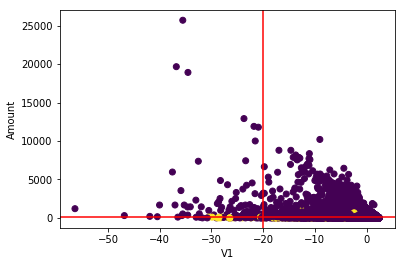

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 設定特徵A的閾值為threshold_A，特徵B的閾值為threshold_B
threshold_A = -20 #V1的50%
threshold_B = 5000/32.47 #Amount>=5000
print(threshold_B)

# 將label指定給顏色
colors = new_df['Class']

# 繪製散佈圖
plt.scatter(new_df['V1'], new_df['Amount'], c=colors)
plt.xlabel('V1')
plt.ylabel('Amount')

# 繪製閾值A
plt.axvline(x=threshold_A, color='r', linestyle='-')

# 繪製閾值B
plt.axhline(y=threshold_B, color='r', linestyle='-')
plt.show()

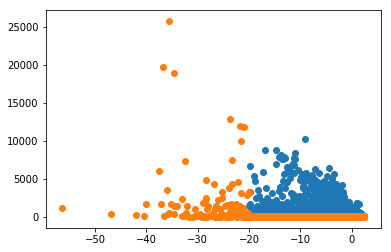

In [9]:
# 建立新的dataframe，只包含特徵A大於閾值且特徵B小於閾值的資料
df1 = new_df.query('V1 >= @threshold_A and Amount >= @threshold_B')

# 建立新的dataframe，只包含特徵A小於等於閾值或特徵B大於等於閾值的資料
df2 = new_df.query('V1 < @threshold_A or Amount < @threshold_B')

X = df1['V1']
Y = df1['Amount']
colors = df1['Class']
plt.scatter(X, Y)

X = df2['V1']
Y = df2['Amount']

plt.scatter(X, Y)
# plt.axhline(y=threshold_B, color='r', linestyle='-')
# plt.axvline(x=threshold_A, color='r', linestyle='-', ymin = threshold_A)
# plt.xlim(-5,)
# plt.ylim(0,)
plt.show()

In [10]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # 設定特徵A的閾值為threshold_A，特徵B的閾值為threshold_B
# threshold_A = -9.203734e-01 #V1的50%
# threshold_B = 5000/32.47 #Amount>=5000
# print(threshold_B)

# # 將label指定給顏色
# colors = df['Class']


# # 繪製散佈圖
# plt.scatter(df['V1'], df['Amount'], c=colors)
# plt.xlabel('V1')
# plt.ylabel('Amount')

# # 繪製閾值A
# plt.axvline(x=threshold_A, color='r', linestyle='-')

# # 繪製閾值B
# plt.axhline(y=threshold_B, color='r', linestyle='-')
# plt.show()

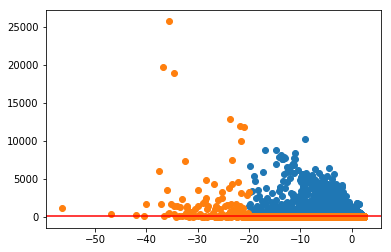

In [11]:
# 建立新的dataframe，只包含特徵A大於閾值且特徵B小於閾值的資料
df1 = df.query('V1 >= @threshold_A and Amount >= @threshold_B')

# 建立新的dataframe，只包含特徵A小於等於閾值或特徵B大於等於閾值的資料
df2 = df.query('V1 < @threshold_A or Amount < @threshold_B')

X = df1['V1']
Y = df1['Amount']
colors = df1['Class']
plt.scatter(X, Y)

X = df2['V1']
Y = df2['Amount']

plt.scatter(X, Y)
plt.axhline(y=threshold_B, color='r', linestyle='-')
# plt.axvline(x=threshold_A, color='r', linestyle='-', ymin = threshold_A)
# plt.xlim(-5,)
# plt.ylim(0,)
plt.show()

In [12]:
df1.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000,38378.000000
mean,93129.640966,-0.564892,-1.573006,-0.364107,0.089041,-0.814122,0.415856,0.523127,-0.156400,-0.084161,-0.160434,-0.037158,0.031373,-0.046887,0.029822,-0.075198,-0.157558,0.031395,0.094017,-0.072347,0.402273,0.134793,-0.003587,-0.033563,-0.021154,-0.010782,0.009992,-0.022538,0.005822,447.741945,0.002554
std,46695.178400,2.243343,2.134129,1.614320,1.500833,1.786346,1.550539,1.841486,1.359149,1.195717,1.057918,1.012049,0.949207,0.938790,0.879750,0.956691,1.037818,0.817634,0.975265,0.892963,1.359040,0.825330,0.784405,1.168121,0.626659,0.599735,0.568757,0.495180,0.450794,495.740952,0.050469
min,1.000000,-19.989586,-29.780328,-18.649853,-5.024097,-40.427726,-17.574835,-31.764946,-73.216718,-8.507059,-14.924655,-4.034718,-17.150405,-5.791881,-18.392091,-4.391307,-13.563273,-23.815636,-9.498746,-4.539840,-19.902611,-34.830382,-7.417140,-44.807735,-2.814898,-10.295397,-2.068561,-22.565679,-11.710896,153.990000,0.000000
25%,51450.500000,-1.513984,-2.074762,-1.270726,-0.870267,-1.512875,-0.473630,-0.420380,-0.310213,-0.890730,-0.740541,-0.819750,-0.428296,-0.659006,-0.392717,-0.693001,-0.762996,-0.414333,-0.509529,-0.617863,-0.025362,-0.097983,-0.495124,-0.360413,-0.354995,-0.335119,-0.369569,-0.128204,-0.033237,200.000000,0.000000
50%,81535.500000,-0.148776,-1.232650,-0.146652,-0.002576,-0.830889,0.145788,0.279595,-0.023459,-0.129732,-0.162301,-0.032765,0.129376,-0.062048,0.062673,-0.056251,-0.071202,0.008874,0.111906,-0.070187,0.318881,0.135305,0.026366,-0.107167,0.042280,0.051254,-0.122548,-0.041376,0.038096,287.840000,0.000000
75%,137191.250000,0.948293,-0.517303,0.756020,0.904651,-0.048263,0.990658,1.129854,0.281390,0.715842,0.498689,0.724179,0.632658,0.567082,0.520993,0.583357,0.510266,0.460806,0.724311,0.461981,0.748889,0.379565,0.533522,0.262930,0.436441,0.366471,0.365192,0.042886,0.096665,493.720000,0.000000
max,172792.000000,2.138423,12.793880,9.382558,11.229502,23.046242,23.917837,44.054461,9.643419,15.594995,23.745136,9.369079,7.848392,4.262851,10.526766,4.765514,5.562388,4.476275,4.079390,4.891062,17.885238,16.223696,10.503090,19.228169,3.695493,3.844345,3.517346,12.152401,16.129609,10199.440000,1.000000


In [13]:
df2.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000,246429.000000
mean,95076.153955,0.087974,0.244975,0.056705,-0.013867,0.126789,-0.064764,-0.081470,0.024357,0.013107,0.024985,0.005787,-0.004886,0.007302,-0.004644,0.011711,0.024538,-0.004889,-0.014642,0.011267,-0.062649,-0.020992,0.000559,0.005227,0.003294,0.001679,-0.001556,0.003510,-0.000907,32.379102,0.001599
std,47605.182678,1.895467,1.413095,1.492436,1.401667,1.259177,1.282901,1.091505,1.164710,1.082143,1.091470,1.021936,1.006678,1.003590,0.970218,0.908145,0.845692,0.854066,0.813779,0.800464,0.608375,0.717077,0.716126,0.487831,0.602243,0.507951,0.467293,0.387317,0.307034,103.836414,0.039954
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-41.484823,-13.434066,-24.588262,-4.797473,-18.683715,-4.008640,-19.214325,-4.498945,-14.129855,-25.162799,-9.335193,-7.213527,-54.497720,-22.797604,-10.933144,-36.666000,-2.836627,-8.696627,-2.604551,-9.895244,-15.430084,0.000000,0.000000
25%,54661.000000,-0.855048,-0.367639,-0.818700,-0.845995,-0.552873,-0.797575,-0.573774,-0.196548,-0.609321,-0.511203,-0.754414,-0.401735,-0.646521,-0.430426,-0.565919,-0.434145,-0.493513,-0.497526,-0.432644,-0.220176,-0.239194,-0.548110,-0.140552,-0.354530,-0.315325,-0.321203,-0.063674,-0.054388,4.130000,0.000000
50%,85185.000000,0.029741,0.183094,0.224508,-0.022010,0.032026,-0.325588,0.018264,0.028647,-0.042396,-0.084993,-0.032757,0.141713,-0.005929,0.048825,0.064036,0.083656,-0.077547,-0.018220,0.012502,-0.085041,-0.049532,0.003482,-0.004804,0.040808,0.010437,-0.037199,0.007467,0.008712,15.170000,0.000000
75%,139683.000000,1.356972,0.891922,1.069083,0.718973,0.674579,0.302237,0.515509,0.334693,0.582728,0.443519,0.742567,0.615902,0.676192,0.488553,0.657599,0.524945,0.390571,0.469326,0.458353,0.074626,0.156398,0.527536,0.140736,0.440189,0.348318,0.228649,0.097658,0.073706,46.220000,0.000000
max,172788.000000,2.454930,22.057729,4.226108,16.875344,34.801666,73.301626,120.589494,20.007208,10.392889,15.331742,12.018913,4.846452,7.126883,7.692209,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,8.361985,22.528412,4.584549,7.519589,3.463246,31.612198,33.847808,25691.160000,1.000000


In [14]:
class_1_count = df1[df1['Class'] == 1].shape[0]
print(class_1_count)

class_1_count2 = df2[df2['Class'] == 1].shape[0]
print(class_1_count2)

98
394


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

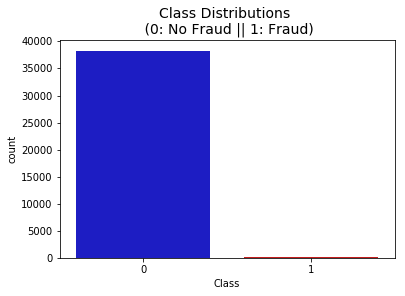

In [15]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df1, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

[1.00000e+00 1.60000e+01 3.60000e+01 ... 1.72743e+05 1.72745e+05
 1.72792e+05]


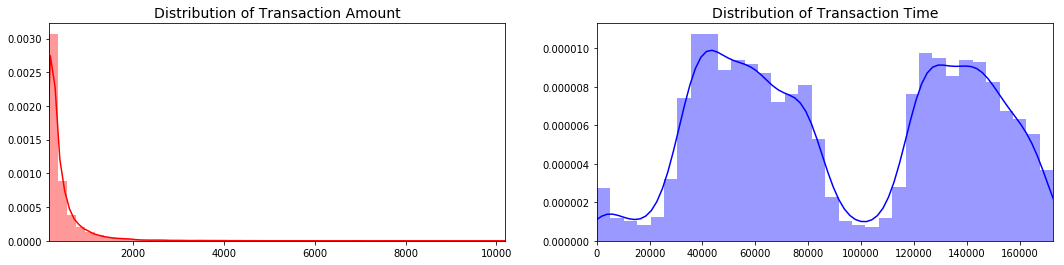

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df1['Amount'].values
time_val = df1['Time'].values

print(time_val)

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

<h2> Scaling and Distributing </h2>

In [17]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df1['scaled_amount'] = rob_scaler.fit_transform(df1['Amount'].values.reshape(-1,1))
df1['scaled_time'] = rob_scaler.fit_transform(df1['Time'].values.reshape(-1,1))

df1.drop(['Time','Amount'], axis=1, inplace=True)

In [18]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df2['scaled_amount'] = rob_scaler.fit_transform(df2['Amount'].values.reshape(-1,1))
df2['scaled_time'] = rob_scaler.fit_transform(df2['Time'].values.reshape(-1,1))

df2.drop(['Time','Amount'], axis=1, inplace=True)

In [19]:
scaled_amount = df1['scaled_amount']
scaled_time = df1['scaled_time']

df1.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df1.insert(0, 'scaled_amount', scaled_amount)
df1.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df1.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
2,0.309206,-0.950942,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
20,-0.191100,-0.950767,0.694885,-1.361819,1.029221,0.834159,-1.191209,1.309109,-0.878586,0.445290,-0.446196,0.568521,1.019151,1.298329,0.420480,-0.372651,-0.807980,-2.044557,0.515663,0.625847,-1.300408,-0.138334,-0.295583,-0.571955,-0.050881,-0.304215,0.072001,-0.422234,0.086553,0.063499,0
51,3.796507,-0.950534,-1.004929,-0.985978,-0.038039,3.710061,-6.631951,5.122103,4.371691,-2.006868,-0.278736,-0.230873,0.145155,-0.063156,-0.799585,-0.341956,-0.930530,0.510510,0.092428,0.823984,1.190398,-0.001980,1.393406,-0.381671,0.969719,0.019445,0.570923,0.333278,0.857373,-0.075538,0
60,-0.404433,-0.950476,0.986063,-0.202965,-0.492768,0.407691,0.305660,-0.230529,0.585028,-0.208225,-0.247503,-0.192253,-0.628317,0.430308,0.811248,0.371566,1.026079,-0.028501,-0.307546,-1.099655,0.010739,0.263505,-0.305874,-1.216555,-0.077602,-0.741341,0.286881,0.200347,-0.075203,0.027271,0
64,-0.150415,-0.950464,-0.522666,1.009923,0.276470,1.475289,-0.707013,0.355243,1.559849,-0.399579,-0.479813,0.516352,0.034330,0.589226,1.426910,0.020510,1.651336,-0.961343,0.246360,-0.407537,0.917399,-0.013016,0.172401,1.011543,0.069666,0.157820,-1.109224,-0.302369,0.318170,0.316910,0


In [20]:
scaled_amount = df2['scaled_amount']
scaled_time = df2['scaled_time']

df2.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df2.insert(0, 'scaled_amount', scaled_amount)
df2.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df2.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,3.194345,-1.001917,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.296507,-1.001917,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
3,2.573770,-1.001905,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,1.302447,-1.001894,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
5,-0.273224,-1.001894,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0


### Splitting the Data (Original DataFrame)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df1['Class'].value_counts()[0]/len(df1) * 100,2), '% of the dataset')
print('Frauds', round(df1['Class'].value_counts()[1]/len(df1) * 100,2), '% of the dataset')

X = df1.drop('Class', axis=1)
y = df1['Class']
print(X.shape)
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.74 % of the dataset
Frauds 0.26 % of the dataset
(38378, 30)
Train: [ 7675  7676  7677 ... 38375 38376 38377] Test: [   0    1    2 ... 7673 7674 8500]
Train: [    0     1     2 ... 38375 38376 38377] Test: [ 7675  7676  7677 ... 15349 15350 15773]
Train: [    0     1     2 ... 38375 38376 38377] Test: [15351 15352 15353 ... 23033 23034 23035]
Train: [    0     1     2 ... 38375 38376 38377] Test: [20695 20696 20697 ... 30705 30706 30707]
Train: [    0     1     2 ... 30705 30706 30707] Test: [29739 29860 30235 ... 38375 38376 38377]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99742696 0.00257304]
[0.99752443 0.00247557]


## Random Under-Sampling:

In [22]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.
# Lets shuffle the data before creating the subsamples

df1 = df1.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df1.loc[df1['Class'] == 1]
non_fraud_df = df1.loc[df1['Class'] == 0][:100]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
79883,-0.060738,-0.271907,-1.322789,1.552768,-2.276921,2.992117,-1.947064,-0.480288,-1.362388,0.953242,-2.329629,-3.393553,3.128440,-3.570394,-0.595198,-3.988415,0.995906,-2.843785,-4.826246,-0.703883,2.152215,0.988493,0.614969,-0.195200,0.590711,-0.233378,-0.164285,-0.277498,0.428610,0.246394,1
34155,0.106087,-0.513169,-0.705179,-0.226829,0.786209,-0.581295,-0.444696,0.026511,2.054926,-0.393099,-0.570263,-0.612675,0.934087,0.679654,0.359060,-0.044215,-0.750983,-0.189095,-0.433597,0.051590,0.869455,0.785378,0.161042,0.182350,0.393475,0.064458,0.210838,1.043929,-0.318048,-0.179937,0
199896,3.565164,0.602380,-1.212682,-2.484824,-6.397186,3.670562,-0.863375,-1.855855,1.017732,-0.544704,-1.703378,-3.739659,1.738124,-2.844449,0.765864,-4.799737,-0.011335,-2.693168,-3.166955,-1.067800,-0.559132,2.908374,1.396872,0.092073,-1.492882,-0.204227,0.532511,-0.293871,0.212663,0.431095,1
96145,0.279722,-0.185530,0.738324,-2.059653,-1.000128,-1.517482,0.669713,3.659995,-1.124718,0.837082,-0.585485,0.499291,-0.071779,-0.746272,0.419537,-0.244266,1.337308,1.848247,-0.438147,-0.346463,0.480359,0.949460,0.546168,0.570622,-0.454589,1.067598,0.458164,-0.072538,-0.027184,0.081626,0
38472,-0.265014,-0.491382,-1.416558,1.019712,0.889689,-0.838063,-0.227857,0.377024,1.829047,-0.106266,-0.607812,-0.299070,1.026444,0.057321,-0.900817,0.442976,-0.125706,0.292258,-0.660992,-0.189200,-0.698470,-0.249541,-0.037412,-0.009524,-0.362950,-0.291439,0.554613,0.285885,-0.067261,0.073423,0


In [23]:
# df1 = df1.sample(frac=1)

# # amount of fraud classes 492 rows.
# fraud_df = df1.loc[df1['Class'] == 1]
# non_fraud_df = df1.loc[df1['Class'] == 0][:100]

# normal_distributed_df = df1

# # Shuffle dataframe rows
# new_df = normal_distributed_df.sample(frac=1, random_state=42)

# new_df.head()

In [24]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df2 = df2.sample(frac=1)

# amount of fraud classes 492 rows.
# fraud_df = df2.loc[df2['Class'] == 1]
# non_fraud_df = df2.loc[df2['Class'] == 0][:100]

# normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
normal_distributed_df = df2
# Shuffle dataframe rows
new_df2 = normal_distributed_df.sample(frac=1, random_state=42)

new_df2.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
233579,-0.212164,0.734328,0.084095,0.905749,-0.358686,-0.626236,0.836942,-0.514465,0.807009,0.109523,-0.167009,-0.647844,0.995975,0.095976,-1.106350,-0.607915,-0.791144,0.481896,0.272929,0.275066,-0.050954,-0.039207,-0.286283,-0.758391,0.123036,0.573382,-0.515259,0.095590,0.214433,0.072825,0
276641,-0.122832,0.964891,2.014815,-1.499484,0.720160,0.026320,-1.897582,0.911461,-2.031837,0.417372,1.525369,0.456698,-2.045279,0.457832,0.296664,-1.514861,-1.612743,-1.617977,0.321618,1.284691,-0.497426,-0.586802,-0.300425,0.142652,0.288203,0.783613,-0.476496,0.707866,0.063423,-0.024772,0
163821,0.552863,0.365223,1.950487,0.002312,-1.761814,1.232470,0.523175,-0.650657,0.504231,-0.200857,0.116805,0.443750,0.257633,0.358875,-1.313311,0.922108,-1.078538,-0.395038,-0.437151,0.074223,0.187086,-0.285207,0.086306,0.326297,-0.068839,-0.416589,0.426044,-0.486299,-0.031266,-0.072543,0
28542,0.330245,-0.589659,-1.847988,1.770230,0.412281,0.853486,-0.645814,-0.144825,-0.191517,1.220817,-0.813990,-1.090681,-1.044957,0.964003,0.542136,0.748280,-0.468402,-0.523776,0.748732,-0.759516,-0.182720,-0.440577,0.157634,0.174332,-0.111143,0.108833,0.187887,-0.382995,-0.490618,-0.100223,0
208864,-0.001901,0.613006,1.979636,0.803506,-1.614363,3.570092,1.227191,-0.287838,0.803775,-0.287717,-1.540702,1.566916,-1.122848,-0.413335,-0.002361,0.697094,-0.566805,0.534289,-0.756319,-0.658704,-1.526608,-0.255460,0.090748,0.200501,0.072677,0.584798,0.299413,0.050076,-0.084263,-0.056728,0


In [25]:
# # Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# # Lets shuffle the data before creating the subsamples

# df2 = df2.sample(frac=1)

# # amount of fraud classes 492 rows.
# # fraud_df = df2.loc[df2['Class'] == 1]
# # non_fraud_df = df2.loc[df2['Class'] == 0][:100]

# normal_distributed_df = df2

# # Shuffle dataframe rows
# new_df2 = normal_distributed_df.sample(frac=1, random_state=42)

# new_df2.head()

##  Equally Distributing and Correlating: 

Distribution of the Classes in the subsample dataset
0    0.505051
1    0.494949
Name: Class, dtype: float64


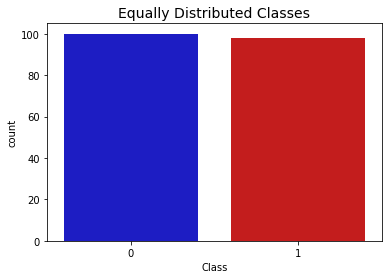

In [26]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

Distribution of the Classes in the subsample dataset
0    0.998401
1    0.001599
Name: Class, dtype: float64


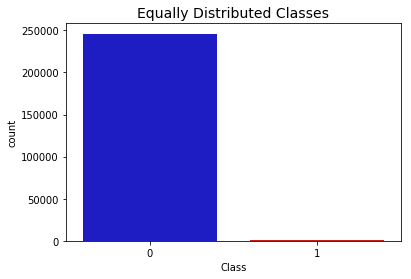

In [27]:
print('Distribution of the Classes in the subsample dataset')
print(new_df2['Class'].value_counts()/len(new_df2))



sns.countplot('Class', data=new_df2, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

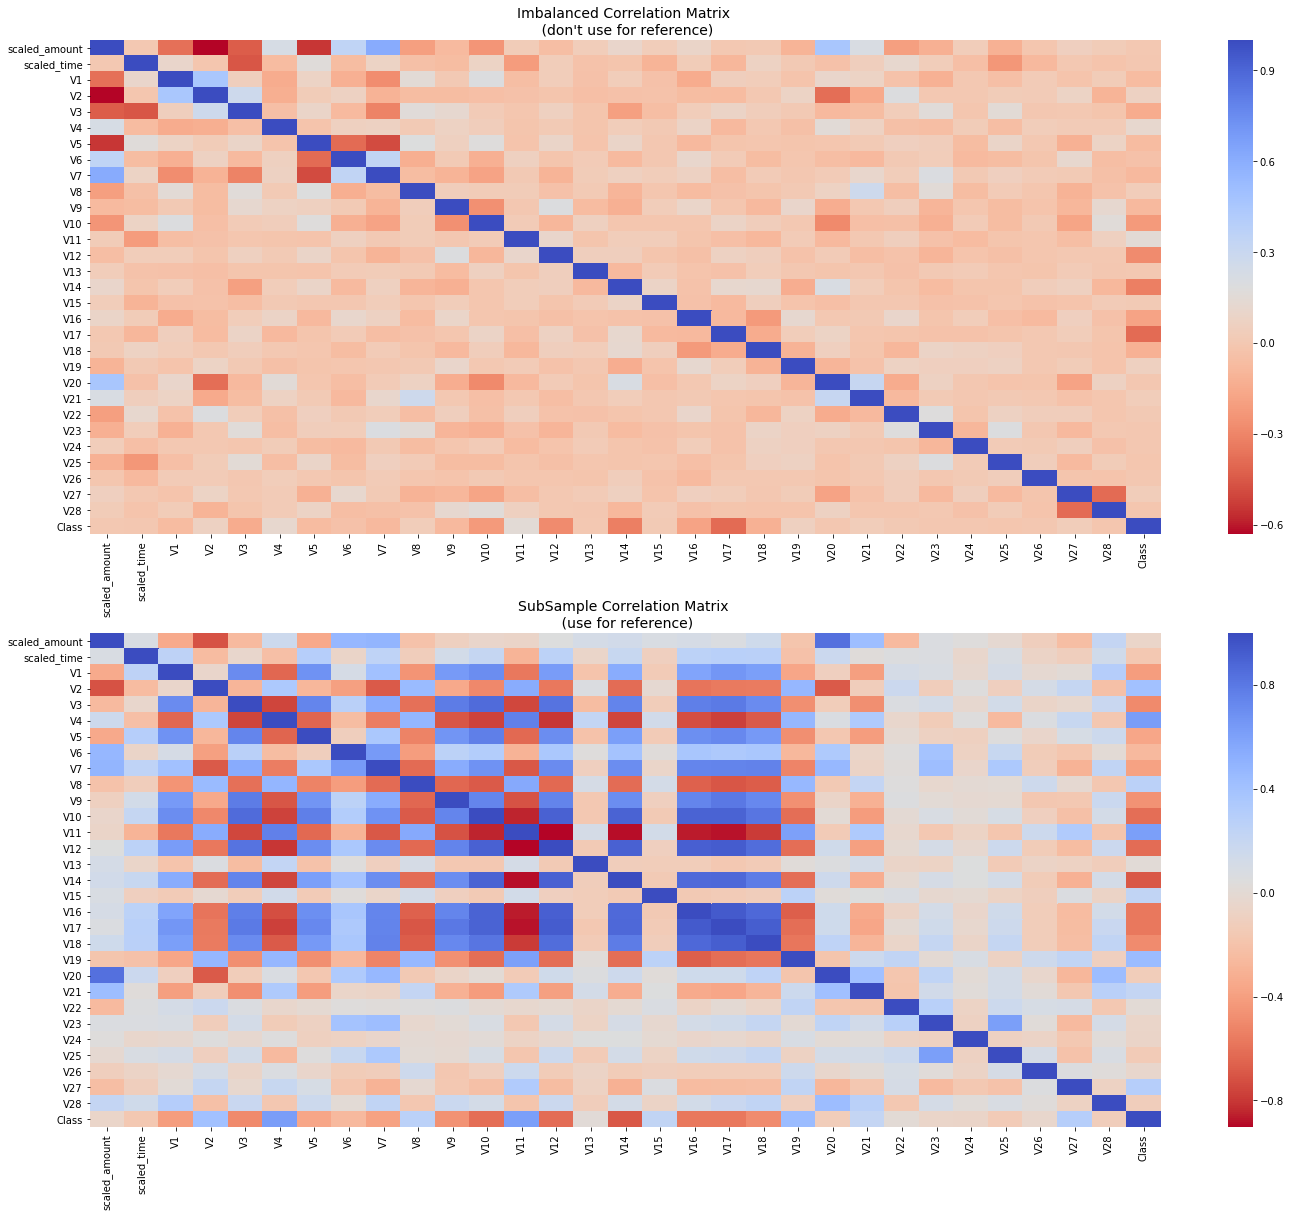

In [28]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df1.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

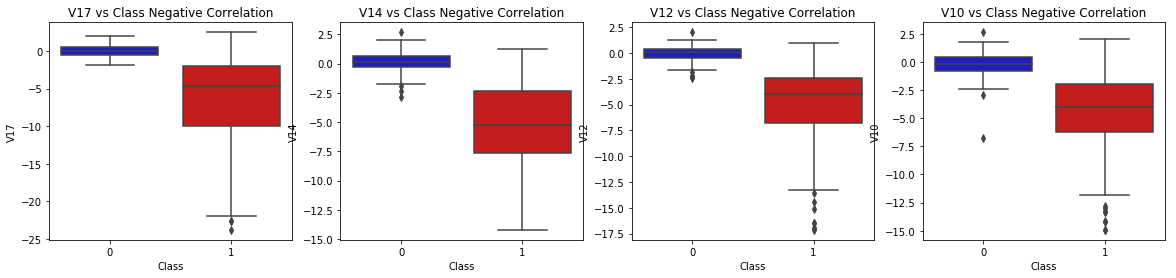

In [29]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

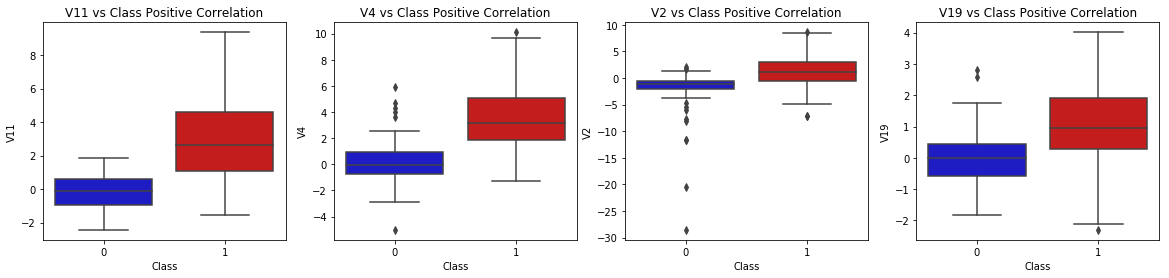

In [30]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## Anomaly Detection:

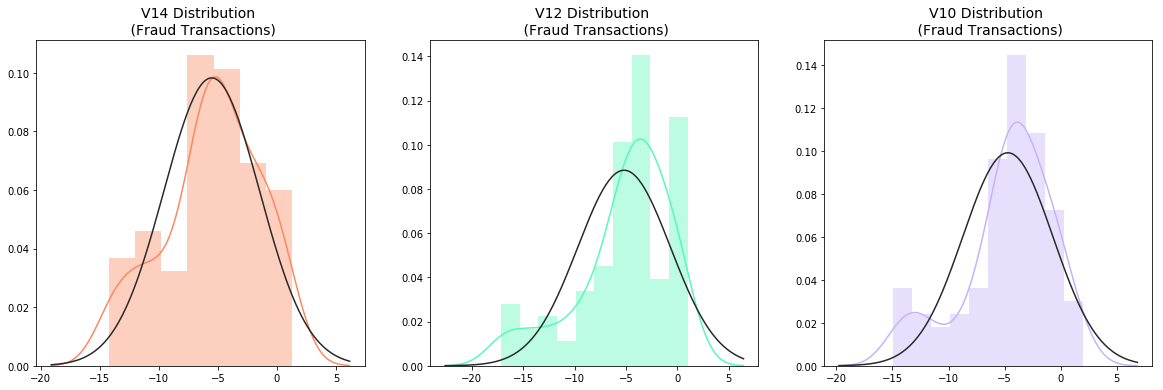

In [31]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [32]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -7.619927890456546 | Quartile 75: -2.3131819364357096
iqr: 5.306745954020837
Cut Off: 7.960118931031255
V14 Lower: -15.580046821487802
V14 Upper: 5.646936994595546
Feature V14 Outliers for Fraud Cases: 0
V10 outliers:[]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -13.394168088310945
V12 Upper: 4.226876255128947
V12 outliers: [-17.003289445516, -17.1504052507291, -16.4655039422141, -16.4655039422141, -14.4686550955305, -13.556130130146801, -15.0941631493865, -17.003289445516]
Feature V12 Outliers for Fraud Cases: 8
Number of Instances after outliers removal: 190
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -11.22245425097699
V10 Upper: 4.089506656090654
V10 outliers: [-14.226698057528699, -14

In [33]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df2['V14'].loc[new_df2['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df2 = new_df2.drop(new_df2[(new_df2['V14'] > v14_upper) | (new_df2['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df2['V12'].loc[new_df2['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df2 = new_df2.drop(new_df2[(new_df2['V12'] > v12_upper) | (new_df2['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df2)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df2['V10'].loc[new_df2['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df2 = new_df2.drop(new_df2[(new_df2['V10'] > v10_upper) | (new_df2['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df2)))

Quartile 25: -9.952818084416545 | Quartile 75: -4.605382129174597
iqr: 5.347435955241949
Cut Off: 8.021153932862923
V14 Lower: -17.97397201727947
V14 Upper: 3.415771803688326
Feature V14 Outliers for Fraud Cases: 5
V10 outliers:[3.4424219959421496, -18.049997689859396, -18.8220867423816, -18.4937733551053, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.212062157678126
V12 Upper: 5.1334109956415155
V12 outliers: [-18.683714633344298, -18.047596570821604, -18.553697009645802, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 246023
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -15.4023075695125
V10 Upper: 4.86891739524726
V10 outliers:

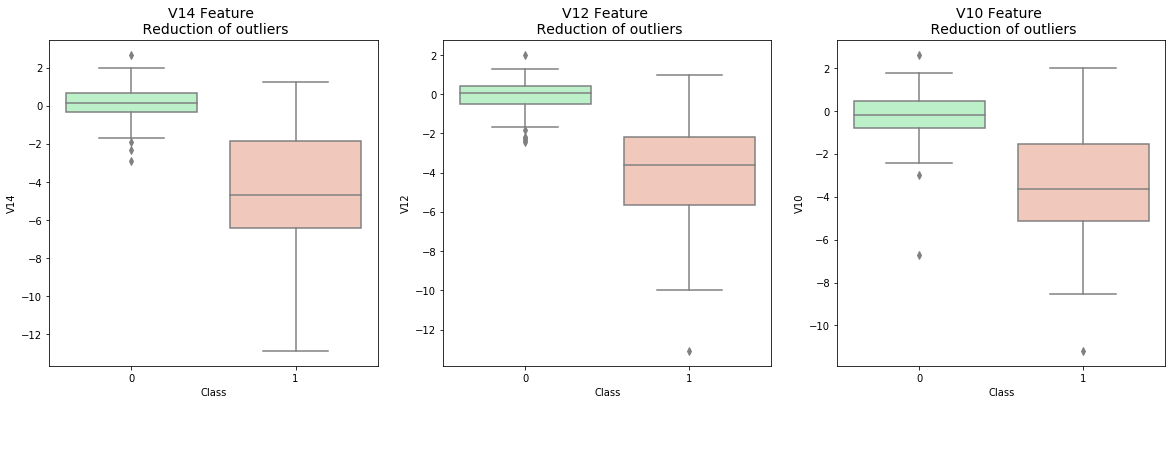

In [34]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

Dimensionality Reduction and Clustering:<h2>Dimensionality Reduction and Clustering: </h2>
<a id="clustering"></a>

<h3>Understanding t-SNE:  </h3>
In order to understand this algorithm you have to understand the following terms: <br>
<ul>
<li> <b> Euclidean Distance </b></li>
<li> <b>Conditional Probability</b> </li>
<li><b>Normal and T-Distribution Plots</b> </li>
</ul> 

**Note:** If you want a simple instructive video look at <a href="https://www.youtube.com/watch?v=NEaUSP4YerM"> StatQuest: t-SNE, Clearly Explained </a> by Joshua Starmer


<h3> Summary: </h3>
<ul> 
<li>t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset. </li>
<li> Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (I shuffle the dataset before running t-SNE)</li>
<li> This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases. </li>
</ul>

In [35]:
new_df

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
79883,-0.060738,-0.271907,-1.322789,1.552768,-2.276921,2.992117,-1.947064,-0.480288,-1.362388,0.953242,-2.329629,-3.393553,3.128440,-3.570394,-0.595198,-3.988415,0.995906,-2.843785,-4.826246,-0.703883,2.152215,0.988493,0.614969,-0.195200,0.590711,-0.233378,-0.164285,-0.277498,0.428610,0.246394,1
34155,0.106087,-0.513169,-0.705179,-0.226829,0.786209,-0.581295,-0.444696,0.026511,2.054926,-0.393099,-0.570263,-0.612675,0.934087,0.679654,0.359060,-0.044215,-0.750983,-0.189095,-0.433597,0.051590,0.869455,0.785378,0.161042,0.182350,0.393475,0.064458,0.210838,1.043929,-0.318048,-0.179937,0
199896,3.565164,0.602380,-1.212682,-2.484824,-6.397186,3.670562,-0.863375,-1.855855,1.017732,-0.544704,-1.703378,-3.739659,1.738124,-2.844449,0.765864,-4.799737,-0.011335,-2.693168,-3.166955,-1.067800,-0.559132,2.908374,1.396872,0.092073,-1.492882,-0.204227,0.532511,-0.293871,0.212663,0.431095,1
96145,0.279722,-0.185530,0.738324,-2.059653,-1.000128,-1.517482,0.669713,3.659995,-1.124718,0.837082,-0.585485,0.499291,-0.071779,-0.746272,0.419537,-0.244266,1.337308,1.848247,-0.438147,-0.346463,0.480359,0.949460,0.546168,0.570622,-0.454589,1.067598,0.458164,-0.072538,-0.027184,0.081626,0
38472,-0.265014,-0.491382,-1.416558,1.019712,0.889689,-0.838063,-0.227857,0.377024,1.829047,-0.106266,-0.607812,-0.299070,1.026444,0.057321,-0.900817,0.442976,-0.125706,0.292258,-0.660992,-0.189200,-0.698470,-0.249541,-0.037412,-0.009524,-0.362950,-0.291439,0.554613,0.285885,-0.067261,0.073423,0
219318,1.301103,0.701493,-2.567207,-1.784275,-0.180747,-1.323187,-1.571668,-0.077918,2.540887,0.179271,0.356186,-2.410292,-1.819997,-0.541500,-1.558779,0.380414,-1.244331,-0.576634,0.309027,0.027251,-0.068686,1.286147,0.705138,0.760804,0.853747,-0.048450,1.445812,1.090863,-0.409823,-0.097450,0
173543,-0.373485,0.466458,-0.365334,-1.370344,0.257064,-0.952257,0.843694,0.158833,0.068696,-0.001296,0.460744,-0.194419,-0.227186,0.281476,0.670164,-0.326140,0.235470,0.896970,-1.335297,0.968676,0.739921,0.683326,0.320913,0.614086,0.395902,-1.376391,-0.614529,1.291831,-0.295232,-0.238639,0
254344,-0.342946,0.876474,-0.129778,0.141547,-0.894702,-0.457662,0.810608,-0.504723,1.373588,-0.209476,0.208494,-1.613618,-0.800150,0.501435,1.118014,-1.816384,-0.681283,0.105946,0.716591,0.205285,-0.051322,0.399447,-0.032643,-0.246526,0.484108,0.359637,-0.435972,-0.248480,0.021527,0.109192,1
101509,0.109492,-0.159533,-1.739334,-1.304655,0.314103,0.053740,-0.058696,0.071260,0.694862,-0.313270,-0.649377,0.517568,-1.356558,-0.238383,0.069579,-0.431690,-0.674724,-1.654162,-0.053961,0.520746,-1.554562,-1.463994,-0.665172,-0.632078,-0.421176,-0.400774,-0.001640,-0.495162,0.031633,0.066280,1
212931,-0.435244,0.670714,-0.321605,1.281170,-1.310050,-0.075666,1.086268,-0.948515,2.780686,-0.748027,-0.962447,-0.337597,-0.737757,0.263558,0.331679,0.578413,-1.230143,-0.796479,-0.508096,-0.631588,-1.245968,-0.405271,0.491918,1.603717,-0.194917,1.157264,-0.112208,-0.565542,0.026016,0.203072,0


In [36]:
print(new_df.shape)

(186, 31)


In [37]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
pca = PCA(n_components=2, random_state=42)
X_reduced_pca = pca.fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
tsvd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42)
X_reduced_svd = tsvd.fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

tsne.fit(X)
# 將 df2 降維至與 df1 相同的空間
# X2_reduced_tsne = tsne.transform(new_df2.drop('Class', axis=1))

T-SNE took 1.2 s
PCA took 0.011 s
Truncated SVD took 0.0095 s


TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=30.0,
     random_state=42, verbose=0)

In [38]:
X.values

array([[-6.07381179e-02, -2.71906882e-01, -1.32278906e+00, ...,
        -2.77497871e-01,  4.28610085e-01,  2.46393746e-01],
       [ 1.06087430e-01, -5.13169059e-01, -7.05179210e-01, ...,
         1.04392888e+00, -3.18047722e-01, -1.79937429e-01],
       [ 3.56516410e+00,  6.02379849e-01, -1.21268170e+00, ...,
        -2.93871104e-01,  2.12663060e-01,  4.31094708e-01],
       ...,
       [ 1.84383086e+00,  7.40313095e-02, -1.36029263e+00, ...,
        -3.32114569e-01, -4.69800302e-01, -1.49500590e+00],
       [-4.00074901e-01,  4.38968635e-01,  1.62389951e+00, ...,
        -1.38563071e-02, -2.12540699e-02,  2.07151122e-04],
       [-3.74336102e-01, -3.25125451e-01,  8.06719447e-01, ...,
        -5.65281310e-01,  7.78230325e-02,  2.61384235e-02]])

(186,)


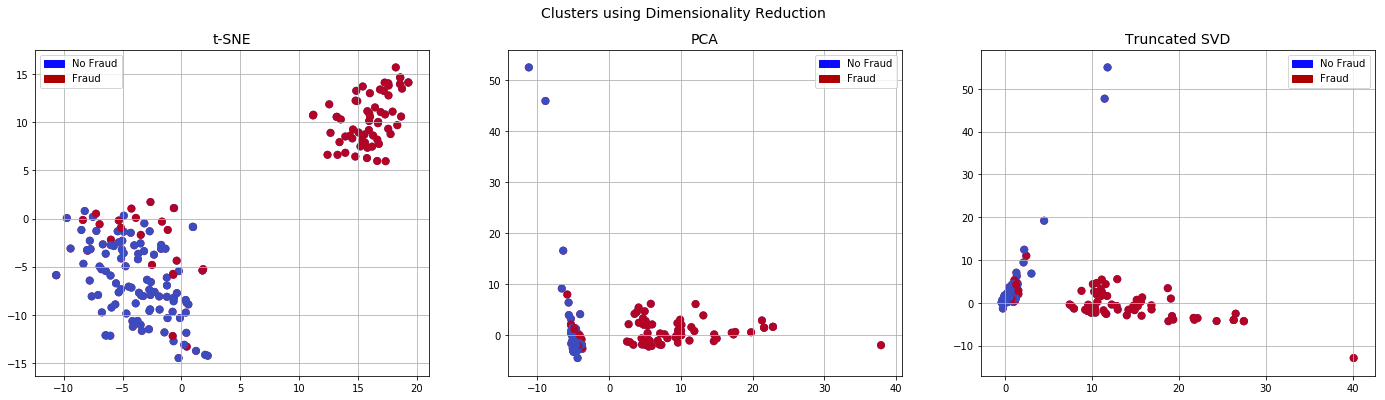

In [40]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# # t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

print( X_reduced_pca[:,1].shape)
# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

(244566, 30)


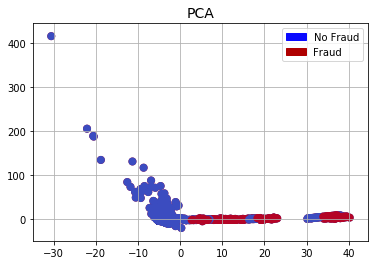

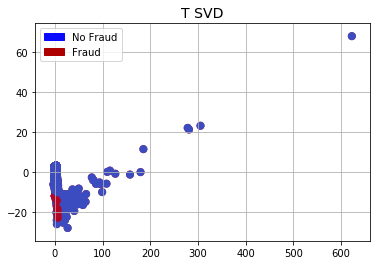

In [41]:
import matplotlib.pyplot as plt

# 將 PCA 方程式應用於 df2 資料集
X2 = new_df2.iloc[:, :30]  # 假設特徵欄位從第 1 到第 28 欄位
y2 = new_df2['Class']
# 使用之前訓練好的 PCA 模型進行轉換

# X2_reduced_tsne = tsne.fit_transform(X2)
X2_reduced_pca = pca.transform(X2)
X2_reduced_tsvd = tsvd.fit_transform(X2)

print(X2.shape)



# TSNE scatter plot
# plt.scatter(X2_reduced_tsne[:, 0], X2_reduced_tsne[:, 1], c=(y2 == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
# plt.scatter(X2_reduced_tsne[:, 0], X2_reduced_tsne[:, 1], c=(y2 == 1), cmap='coolwarm', label='Fraud', linewidths=2)
# plt.title('TSNE', fontsize=14)
# plt.grid(True)
# plt.legend(handles=[blue_patch, red_patch])
# plt.show()

# 取得 PCA 投影的前兩個主成分
PC1 = X2_reduced_pca[:, 0]
PC2 = X2_reduced_pca[:, 1]

# PCA scatter plot
plt.scatter(PC1, PC2, c=(y2 == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(PC1, PC2, c=(y2 == 1), cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('PCA', fontsize=14)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])
plt.show()

# tsvd scatter plot
plt.scatter(X2_reduced_tsvd[:, 0], X2_reduced_tsvd[:, 1], c=(y2 == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X2_reduced_tsvd[:, 0], X2_reduced_tsvd[:, 1], c=(y2 == 1), cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('T SVD', fontsize=14)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])
plt.show()



In [42]:
# X2_reduced_tsne = tsne.fit_transform(X2)
# ㄌ# TSNE scatter plot
# plt.scatter(X2_reduced_tsne[:, 0], X2_reduced_tsne[:, 1], c=(y2 == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
# plt.scatter(X2_reduced_tsne[:, 0], X2_reduced_tsne[:, 1], c=(y2 == 1), cmap='coolwarm', label='Fraud', linewidths=2)
# plt.title('TSNE', fontsize=14)
# plt.grid(True)
# plt.legend(handles=[blue_patch, red_patch])
# plt.show()

In [43]:
print(X2.shape)

(244566, 30)


# 閾值內資料的pca

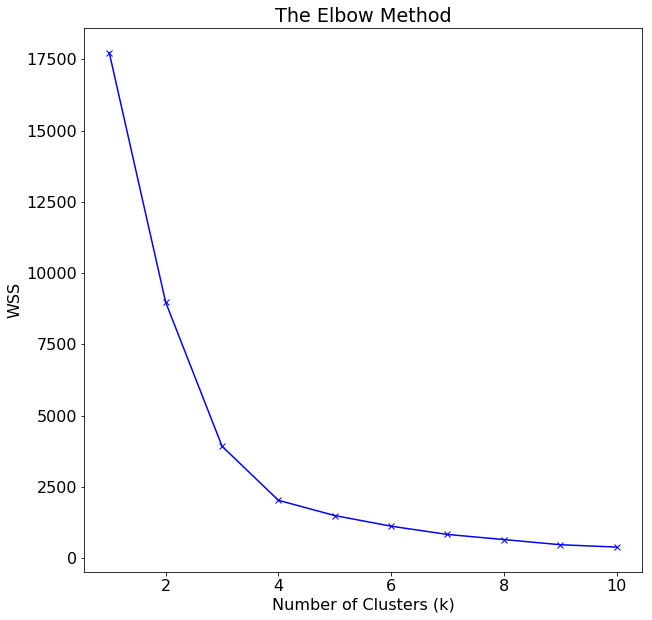

In [44]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 設置KMeans的K值範圍
K = range(1, 11)

# 計算每個K值對應的WSS值
wss = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_reduced_pca)
    wss.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 16

# 繪製WSS vs. K曲線
plt.plot(K, wss, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSS')
plt.title('The Elbow Method')
plt.show()

In [45]:
from sklearn.cluster import KMeans
import numpy as np

# 加載數據，假設你的數據存儲在data變量中
data = X_reduced_pca

# 創建KMeans對象，指定分為3群
kmeans = KMeans(n_clusters=4)

# 使用KMeans對數據進行聚類
kmeans.fit(data)

# 獲取每個數據點所屬的群
labels = kmeans.labels_

# 從每個群中隨機抽樣3000個點
num_samples = 50
samples = []
for i in range(4):
    # 獲取第i個群的所有數據點
    cluster_data = data[labels == i]
    
    # 如果該群的數據點數量小於3000，直接將所有數據點加入樣本集合中
    if len(cluster_data) <= num_samples:
        samples.extend(cluster_data)
    else:
        # 從該群中隨機抽樣3000個數據點
        sample_indices = np.random.choice(len(cluster_data), num_samples, replace=False)
        samples.extend(cluster_data[sample_indices])


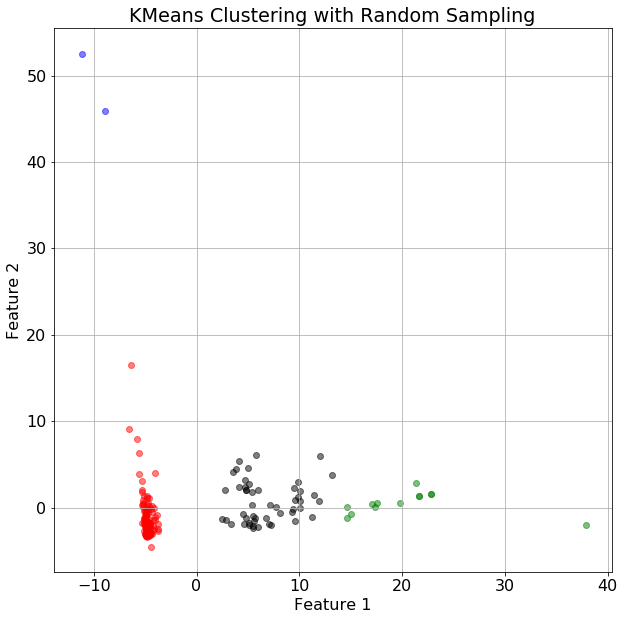

In [46]:
import matplotlib.pyplot as plt

# 定義3種不同顏色，分別代表3個群
colors = ['red', 'green', 'blue', 'k']

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 16


# 畫出散點圖，標記每個數據點所屬的群
for i in range(4):
    cluster_data = data[labels == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=colors[i], alpha=0.5)

# 加上格線
plt.grid(True)

# 設置圖片標題和坐標軸標籤
plt.title('KMeans Clustering with Random Sampling')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# PCA 

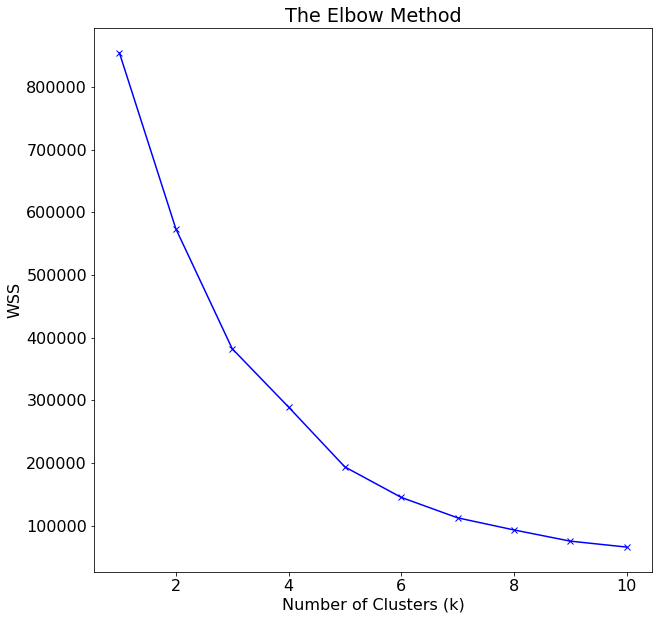

In [47]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 設置KMeans的K值範圍
K = range(1, 11)

# 計算每個K值對應的WSS值
wss = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X2_reduced_pca)
    wss.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 16

# 繪製WSS vs. K曲線
plt.plot(K, wss, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSS')
plt.title('The Elbow Method')
plt.show()

In [48]:
from sklearn.cluster import KMeans
import numpy as np

# 加載數據，假設你的數據存儲在data變量中
data_pca = X2_reduced_pca

# 創建KMeans對象，指定分為3群
kmeans = KMeans(n_clusters=8)

# 使用KMeans對數據進行聚類
kmeans.fit(data_pca)

# 獲取每個數據點所屬的群
labels = kmeans.labels_

# 從每個群中隨機抽樣3000個點
num_samples = 50
samples = []
for i in range(8):
    # 獲取第i個群的所有數據點
    cluster_data = data_pca[labels == i]
    
    # 如果該群的數據點數量小於3000，直接將所有數據點加入樣本集合中
    if len(cluster_data) <= num_samples:
        samples.extend(cluster_data)
    else:
        # 從該群中隨機抽樣3000個數據點
        sample_indices = np.random.choice(len(cluster_data), num_samples, replace=False)
        samples.extend(cluster_data[sample_indices])

Cluster 0: 192065 samples
Cluster 1: 1 samples
Cluster 2: 94 samples
Cluster 3: 52063 samples
Cluster 4: 17 samples
Cluster 5: 251 samples
Cluster 6: 6 samples
Cluster 7: 69 samples


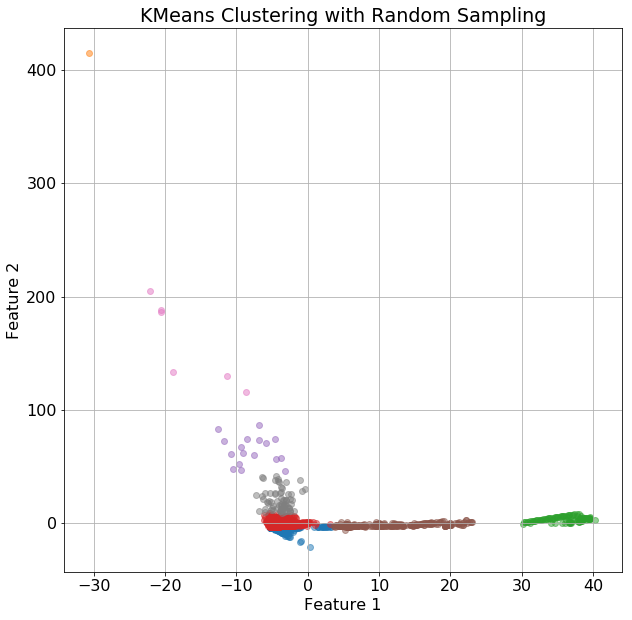

In [49]:
import matplotlib.pyplot as plt

# 定義3種不同顏色，分別代表3個群
# colors = ['red', 'green', 'blue']

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 16


# 畫出散點圖，標記每個數據點所屬的群
for i in range(8):
    cluster_data = data_pca[labels == i]
    print(f"Cluster {i}: {cluster_data.shape[0]} samples")
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], alpha=0.5)

# 加上格線
plt.grid(True)

# 設置圖片標題和坐標軸標籤
plt.title('KMeans Clustering with Random Sampling')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# plt.xlim(-10, 30)
# plt.ylim(-10, 30)
plt.show()

# 把PCADF cluster 和他的 Class分在一起

Cluster 0: 192065 samples, 74 frauds (0.04%), 191991 non-frauds (99.96%)
Cluster 1: 1 samples, 0 frauds (0.00%), 1 non-frauds (100.00%)
Cluster 2: 94 samples, 67 frauds (71.28%), 27 non-frauds (28.72%)
Cluster 3: 52063 samples, 7 frauds (0.01%), 52056 non-frauds (99.99%)
Cluster 4: 17 samples, 0 frauds (0.00%), 17 non-frauds (100.00%)
Cluster 5: 251 samples, 218 frauds (86.85%), 33 non-frauds (13.15%)
Cluster 6: 6 samples, 0 frauds (0.00%), 6 non-frauds (100.00%)
Cluster 7: 69 samples, 0 frauds (0.00%), 69 non-frauds (100.00%)


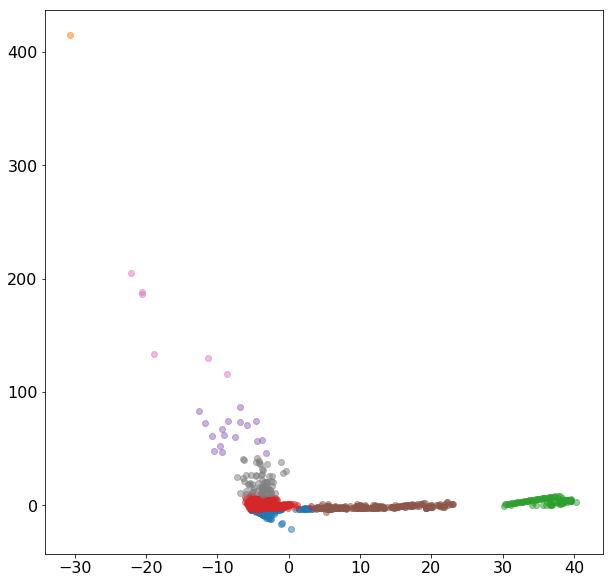

In [50]:
cluster_data_with_label = []

for i in range(8):
    cluster_data = data_pca[labels == i]
    cluster_y = y2[labels == i]
    # 添加分类特征列
    cluster_data_with_label_i = np.c_[cluster_data, np.ones(cluster_data.shape[0]) * i]
    cluster_data_with_label += cluster_data_with_label_i.tolist()
    n_samples = cluster_y.shape[0]
    n_frauds = np.sum(cluster_y == 1)
    n_non_frauds = np.sum(cluster_y == 0)
    print(f"Cluster {i}: {n_samples} samples, {n_frauds} frauds ({n_frauds/n_samples*100:.2f}%), {n_non_frauds} non-frauds ({n_non_frauds/n_samples*100:.2f}%)")
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], alpha=0.5)
    
pcadf = pd.DataFrame(cluster_data_with_label,columns=["Feature 1", "Feature 2", "Cluster"])


Cluster 0: 192065 samples, 74 frauds (0.04%), 191991 non-frauds (99.96%)
Cluster 1: 1 samples, 0 frauds (0.00%), 1 non-frauds (100.00%)
Cluster 2: 94 samples, 67 frauds (71.28%), 27 non-frauds (28.72%)
Cluster 3: 52063 samples, 7 frauds (0.01%), 52056 non-frauds (99.99%)
Cluster 4: 17 samples, 0 frauds (0.00%), 17 non-frauds (100.00%)
Cluster 5: 251 samples, 218 frauds (86.85%), 33 non-frauds (13.15%)
Cluster 6: 6 samples, 0 frauds (0.00%), 6 non-frauds (100.00%)
Cluster 7: 69 samples, 0 frauds (0.00%), 69 non-frauds (100.00%)
        Feature 1  Feature 2  Cluster  Class
0       -4.354990  -3.720920      0.0    0.0
1       -5.007274  -3.953642      0.0    0.0
2       -4.693134  -3.102996      0.0    0.0
3       -4.142236  -3.362247      0.0    0.0
4       -4.480337  -3.423151      0.0    0.0
5       -4.202582  -3.830080      0.0    0.0
6       -4.525705  -3.454185      0.0    0.0
7       -4.768293  -3.796783      0.0    0.0
8       -4.460243  -3.968464      0.0    0.0
9       -4.133830

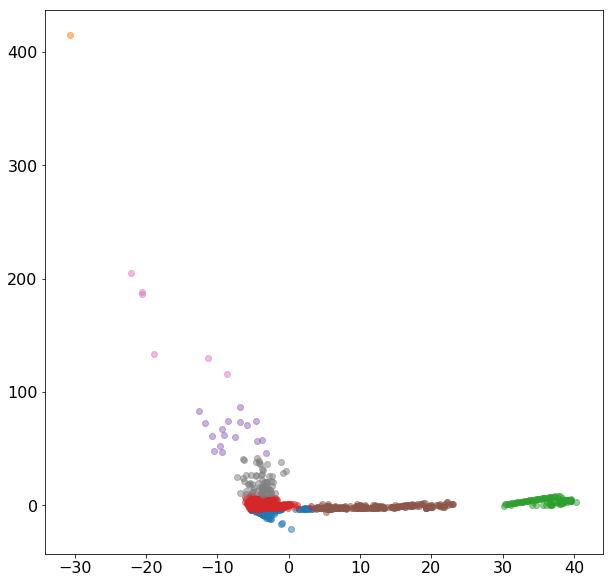

In [51]:
import pandas as pd
import numpy as np

cluster_data_with_label = []

for i in range(8):
    cluster_data = data_pca[labels == i]
    cluster_y = y2[labels == i]
    # 添加分类特征列
    cluster_data_with_label_i = np.c_[cluster_data, np.ones(cluster_data.shape[0]) * i, cluster_y]
    cluster_data_with_label += cluster_data_with_label_i.tolist()
    n_samples = cluster_y.shape[0]
    n_frauds = np.sum(cluster_y == 1)
    n_non_frauds = np.sum(cluster_y == 0)
    print(f"Cluster {i}: {n_samples} samples, {n_frauds} frauds ({n_frauds/n_samples*100:.2f}%), {n_non_frauds} non-frauds ({n_non_frauds/n_samples*100:.2f}%)")
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], alpha=0.5)

pcadf = pd.DataFrame(cluster_data_with_label, columns=["Feature 1", "Feature 2", "Cluster", "Class"])

print(pcadf)

In [52]:
# 驗證一下到底對不對
cluster_ratios = pcadf.groupby('Cluster')['Class'].mean() * 100
print(cluster_ratios)

Cluster
0.0     0.038529
1.0     0.000000
2.0    71.276596
3.0     0.013445
4.0     0.000000
5.0    86.852590
6.0     0.000000
7.0     0.000000
Name: Class, dtype: float64


In [53]:
old_df = pcadf

# 创建新的DataFrame用于存储移动的样本
new_df = pd.DataFrame(columns=pcadf.columns)

# 从pcadf中随机抽取100个数据
random_samples = pcadf.sample(n=100)

# 将抽取的数据从pcadf中移除，并添加到new_df中
for _, sample in random_samples.iterrows():
    cluster = int(sample['Cluster'])
    new_df = new_df.append(sample)
    pcadf = pcadf.drop(index=sample.name)

# 重置索引
new_df.reset_index(drop=True, inplace=True)
pcadf.reset_index(drop=True, inplace=True)

# 打印新的DataFrame
print(new_df)
print(len(new_df))

    Feature 1  Feature 2  Cluster  Class
0   -4.326629  -3.916954      0.0    0.0
1   -4.614531  -3.720747      0.0    0.0
2   -4.812248  -3.680886      0.0    0.0
3   -4.896155  -3.530631      0.0    0.0
4   -4.420495  -3.904069      0.0    0.0
5   -4.790423  -3.173968      0.0    0.0
6   -4.695696  -3.894291      0.0    0.0
7   -4.770169  -3.502336      0.0    0.0
8   -4.352056  -3.859562      0.0    0.0
9   -4.453869  -2.686708      3.0    0.0
10  -4.882530  -3.607453      0.0    0.0
11  -4.545570  -3.717430      0.0    0.0
12  -4.367894  -2.399780      3.0    0.0
13  -4.682983  -3.674433      0.0    0.0
14  -4.789184  -3.202931      0.0    0.0
15  -4.623297  -2.511646      3.0    0.0
16  -4.973754  -2.964624      0.0    0.0
17  -4.246733  -3.734089      0.0    0.0
18  -4.568346  -3.731540      0.0    0.0
19  -4.957377  -2.715825      3.0    0.0
20  -4.366263  -3.848921      0.0    0.0
21  -4.595418  -3.708688      0.0    0.0
22  -4.967317  -3.864039      0.0    0.0
23  -4.391060  -

<h2> Classifiers (UnderSampling):  </h2>

In [57]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [58]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [60]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [61]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 89.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 96.0 % accuracy score
Classifiers:  SVC Has a training score of 95.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 96.0 % accuracy score


In [62]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [63]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  89.17%
Knears Neighbors Cross Validation Score 96.11%
Support Vector Classifier Cross Validation Score 95.0%
DecisionTree Classifier Cross Validation Score 95.0%


In [65]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

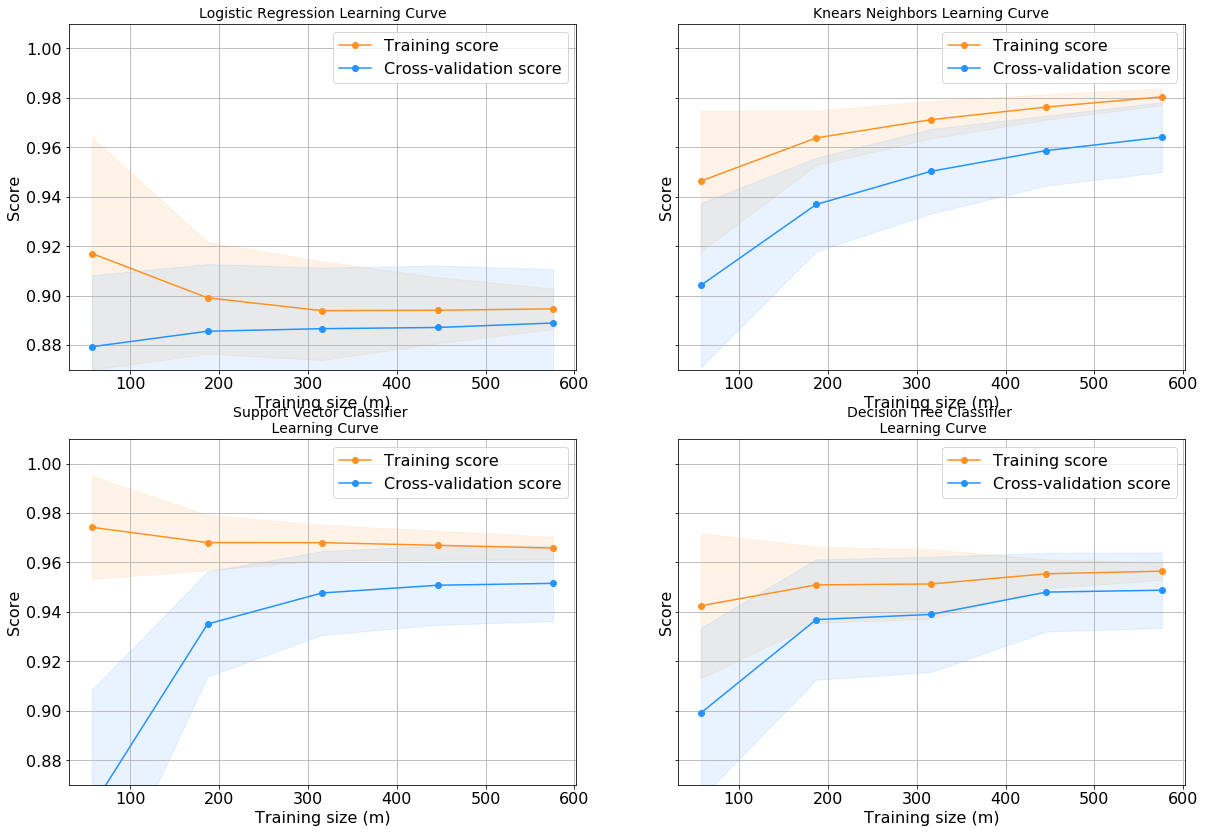

In [66]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [67]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [68]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9545601003934338
KNears Neighbors:  0.9554334554334555
Support Vector Classifier:  0.9901302401302402
Decision Tree Classifier:  0.9597069597069597


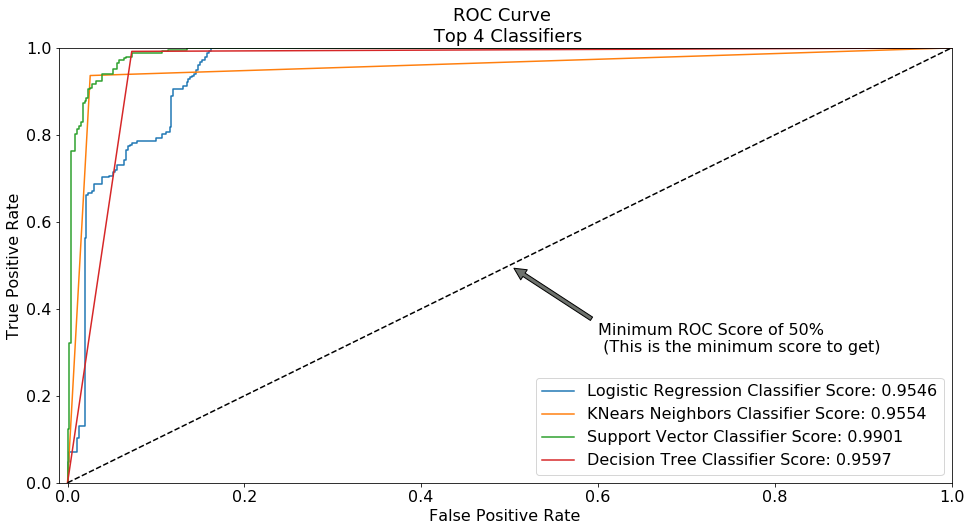

In [69]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## A Deeper Look into LogisticRegression:

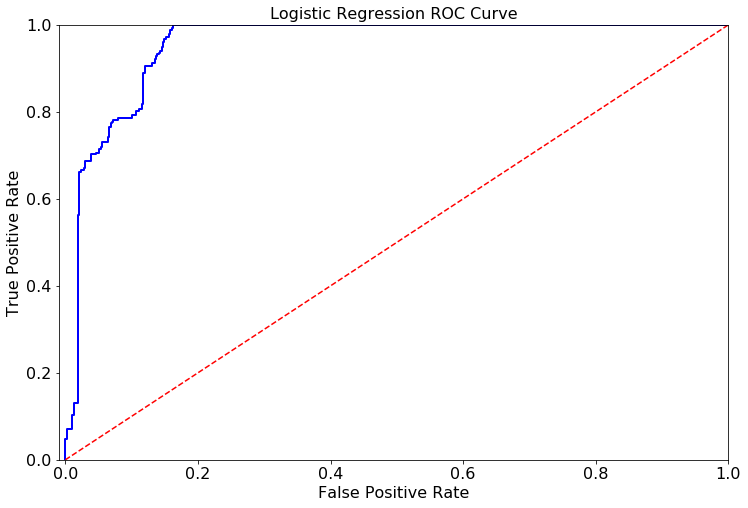

In [70]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [71]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [76]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [77]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.04


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.04')

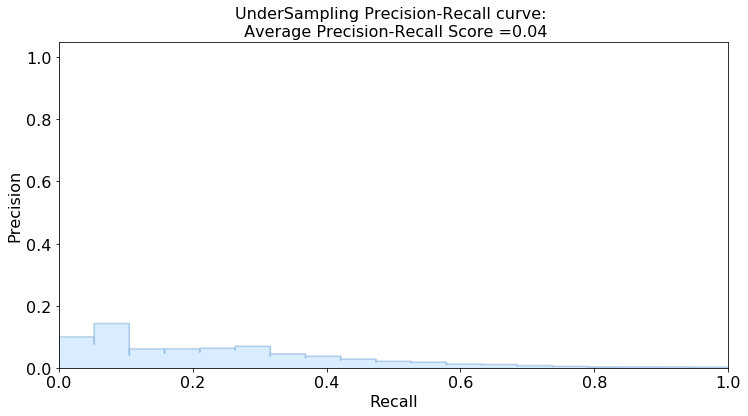

In [78]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

### SMOTE Technique (Over-Sampling):

In [79]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 30703 | Length of y (train): 30703
Length of X (test): 7675 | Length of y (test): 7675
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9512416935787567
precision: 0.05711519363282373
recall: 0.8466666666666667
f1: 0.1052399112510645
---------------------------------------------------------------------------------------------------------------------------------------


In [80]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.94      0.97      7656
       Fraud       0.03      0.79      0.06        19

    accuracy                           0.94      7675
   macro avg       0.52      0.87      0.52      7675
weighted avg       1.00      0.94      0.97      7675



In [81]:
y_score = best_est.decision_function(original_Xtest)

In [82]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.78


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.78')

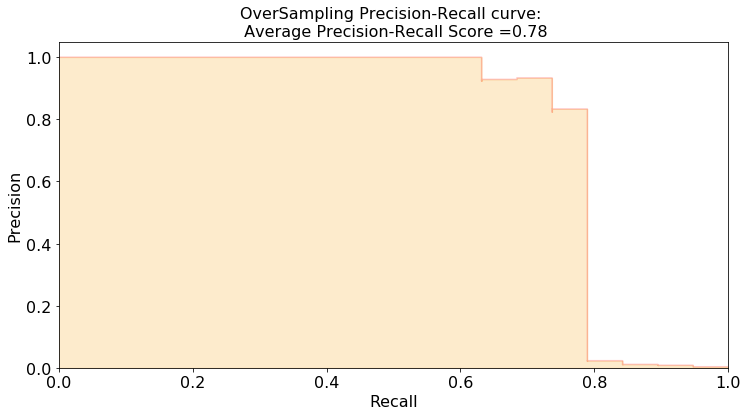

In [83]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [84]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [85]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :2.4609289169311523 sec
